**Install and Import Libraries:**

In [1]:
# Install required libraries
!pip install datasets evaluate nlpaug transformers scikit-learn torch textblob

# Import libraries for NLP tasks, data visualization, and augmentation
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# Import Hugging Face tools
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)

# Import scikit-learn functions
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# NLP Augmentation
import nlpaug.augmenter.word as naw

# Hugging Face Datasets
from datasets import Dataset

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

**Load and Preprocess Dataset:**

In [2]:
#**Load Dataset**
# This line loads the dataset from the specified CSV file into a pandas DataFrame.
file_path = '/content/updated_result_with_BERT.csv'  # Path to the CSV file
df = pd.read_csv(file_path)  # Load the dataset into a pandas DataFrame

# **Data Cleaning Function**
# This function cleans each column by filling missing values and performing basic text preprocessing.
def clean_column(column, default_value="no information provided"):
    # Fill missing values with the specified default value and convert all text to lowercase and strip extra spaces.
    return column.fillna(default_value).astype(str).str.lower().str.strip()

# **Clean Dataset**
# Applying the `clean_column` function to specific columns to handle missing data and standardize text formatting.
df['Pseudonymized_Diagnosis'] = clean_column(df['Pseudonymized_Diagnosis'], "no diagnosis provided")  # Clean 'Diagnosis' column
df['Pseudonymized_Patient History'] = clean_column(df['Pseudonymized_Patient History'], "no history provided")  # Clean 'Patient History' column
df['Pseudonymized_symptoms'] = clean_column(df['Pseudonymized_symptoms'], "no symptoms reported")  # Clean 'symptoms' column
df['Pseudonymized_Diagnosis Category'] = clean_column(df['Pseudonymized_Diagnosis Category'], "Unknown")  # Clean 'Diagnosis Category' column

# **Combine Text Fields**
# Concatenate the 'Diagnosis', 'Patient History', and 'symptoms' columns into one single text column.
df['combined_text'] = (
    df['Pseudonymized_Diagnosis'] + " " + df['Pseudonymized_Patient History'] + " " + df['Pseudonymized_symptoms']
).replace("", "no information provided").fillna("no information provided")
# Replace any empty strings with "no information provided" and fill any remaining missing values with the same default value.

# **Encode Target Labels**
# Convert the categorical 'Diagnosis Category' column into numerical values for model training.
df['target'] = df['Pseudonymized_Diagnosis Category'].astype('category').cat.codes  # Encode target labels as integers
# Create a dictionary to map each label (category) to its corresponding integer code.
label_encoder = dict(enumerate(df['Pseudonymized_Diagnosis Category'].astype('category').cat.categories))


**Display the first few rows of the dataset to understand its structure and contents:**

In [3]:
print(df.head())  # Show the first few rows of the DataFrame to verify the data.

   patient_id  age gender                             Diagnosis  \
0        1049   62      M    Avascular Necrosis of the Left Hip   
1        7622   61      F    Avascular Necrosis of the Left Hip   
2        8063   59      F    Avascular Necrosis of the Left Hip   
3        9737   21      M  Avascular Necrosis of Bilateral Hips   
4        4318   53      M  Avascular Necrosis of Bilateral Hips   

                      Remarks  doctor_id  \
0  Further evaluation needed.       2504   
1  Routine check-up required.       5825   
2  Further evaluation needed.       9898   
3  Routine check-up required.       3969   
4          Patient is stable.       5984   

                                     Patient History  age_group  \
0  The patient complains of persistent pain in th...          4   
1  MRI confirmed avascular necrosis of the left h...          4   
2  Gradual onset of left hip pain with restricted...          3   
3  MRI indicates avascular necrosis in both hips....          2 

**Augment Data to Balance Classes:**

In [4]:
# **Augmentation Function Using Synonyms**
# This function augments the text by replacing words with their synonyms using WordNet.
def augment_with_synonyms(text):
    aug = naw.SynonymAug(aug_src='wordnet', aug_min=1, aug_max=2)  # Create a synonym augmenter using WordNet with 1 to 2 synonyms per word
    try:
        return aug.augment(text)  # Apply augmentation to the input text
    except Exception:  # If any error occurs during augmentation
        return text  # Return the original text if an error occurs

# **Balance Classes Using Augmentation**
# This function balances the classes in the dataset by augmenting text data for underrepresented classes.
def balance_classes(dataframe, target_column, text_column, min_class_size):
    augmented_data = []  # List to store augmented data for each class
    for category in dataframe[target_column].unique():  # Loop through each unique category in the target column
        subset = dataframe[dataframe[target_column] == category]  # Select subset of the dataframe for the current class
        while len(subset) < min_class_size:  # Continue augmenting until the class size reaches the minimum size
            augmented_subset = subset.copy()  # Create a copy of the subset to augment
            augmented_subset[text_column] = augmented_subset[text_column].apply(augment_with_synonyms)  # Apply synonym augmentation to the text column
            subset = pd.concat([subset, augmented_subset], ignore_index=True)  # Concatenate the augmented data with the original subset
        augmented_data.append(subset)  # Add the augmented subset for the current class to the list
    return pd.concat(augmented_data, ignore_index=True)  # Concatenate all augmented subsets and return the final balanced dataframe

# **Apply Class Balancing**
# This line calls the `balance_classes` function to balance the classes by augmenting underrepresented classes.
df_balanced = balance_classes(df, 'Pseudonymized_Diagnosis Category', 'combined_text', min_class_size=500)  # Balance classes in the dataframe with a minimum class size of 500


Streaming output truncated to the last 5000 lines.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_dat

**Tokenize and Prepare Dataset:**

In [5]:
# **Tokenizer**
# Load the pre-trained DistilBERT tokenizer from Hugging Face's model hub
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')  # Use 'distilbert-base-uncased' tokenizer

# **Tokenization Function**
# This function takes a list of text and returns the tokenized input ready for model input
def tokenize_function(texts):
    return tokenizer(
        texts.tolist(),  # Convert the list of text data to a list (if it's a pandas series)
        padding="max_length",  # Pad the sequences to the maximum length (256 tokens in this case)
        truncation=True,  # Truncate texts that exceed the maximum length
        max_length=256  # Set the maximum sequence length to 256 tokens
    )

# **Convert to Hugging Face Dataset**
# This function converts the tokenized data and corresponding labels into a Hugging Face Dataset format
def create_dataset(encodings, labels):
    return Dataset.from_dict({
        'input_ids': encodings['input_ids'],  # Extract 'input_ids' from the tokenized data
        'attention_mask': encodings['attention_mask'],  # Extract 'attention_mask' from the tokenized data
        'labels': torch.tensor(labels.tolist(), dtype=torch.long)  # Convert labels to PyTorch tensors of type long
    })

# **Tokenize Entire Dataset**
# Tokenize the entire 'combined_text' column from the balanced dataframe
data_encodings = tokenize_function(df_balanced['combined_text'])  # Tokenize the text column of the dataframe
full_dataset = create_dataset(data_encodings, df_balanced['target'])  # Create a Hugging Face Dataset from tokenized data and labels


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [6]:
# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_balanced['combined_text'], df_balanced['target'], test_size=0.2, random_state=42
)

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(texts):
    return tokenizer(texts.tolist(), padding="max_length", truncation=True, max_length=256)

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

# Convert to HuggingFace Dataset
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': torch.tensor(train_labels.tolist(), dtype=torch.long)
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': torch.tensor(val_labels.tolist(), dtype=torch.long)
})

In [7]:
# Load DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(df_balanced['Pseudonymized_Diagnosis Category'].unique())
)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(df_balanced['target']), y=df_balanced['target'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.1,
    logging_dir='./logs',
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    report_to="none",
)

# Metrics for evaluation
def compute_metrics(pred):
    predictions = np.argmax(pred.predictions, axis=1)
    return {"accuracy": accuracy_score(pred.label_ids, predictions)}

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Train the model
trainer.train()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-7-0d23ad6f3f23>:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.009807,0.996641
2,No log,0.010935,0.996641
3,0.131600,0.001278,1.000000
4,0.131600,0.000826,1.000000
5,0.002600,0.000744,1.000000


TrainOutput(global_step=1120, training_loss=0.060054890385695864, metrics={'train_runtime': 154.3195, 'train_samples_per_second': 115.637, 'train_steps_per_second': 7.258, 'total_flos': 1182024677422080.0, 'train_loss': 0.060054890385695864, 'epoch': 5.0})

**Classification Report:**

In [8]:
# Generate predictions from the trained model on the validation dataset
predictions = trainer.predict(val_dataset)

# Extract the predicted labels by taking the index of the highest prediction probability
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Generate a classification report to summarize precision, recall, F1-score, etc.
print("Classification Report:")
print(classification_report(val_labels, predicted_labels, target_names=label_encoder.values()))

Classification Report:
                           precision    recall  f1-score   support

   bone-related disorders       1.00      1.00      1.00       115
    hip-related disorders       1.00      1.00      1.00       264
musculoskeletal disorders       1.00      1.00      1.00       148
                    other       1.00      1.00      1.00       141
         spinal disorders       1.00      1.00      1.00       113
                  unknown       1.00      1.00      1.00       112

                 accuracy                           1.00       893
                macro avg       1.00      1.00      1.00       893
             weighted avg       1.00      1.00      1.00       893



**Confusion Matrix plot:**

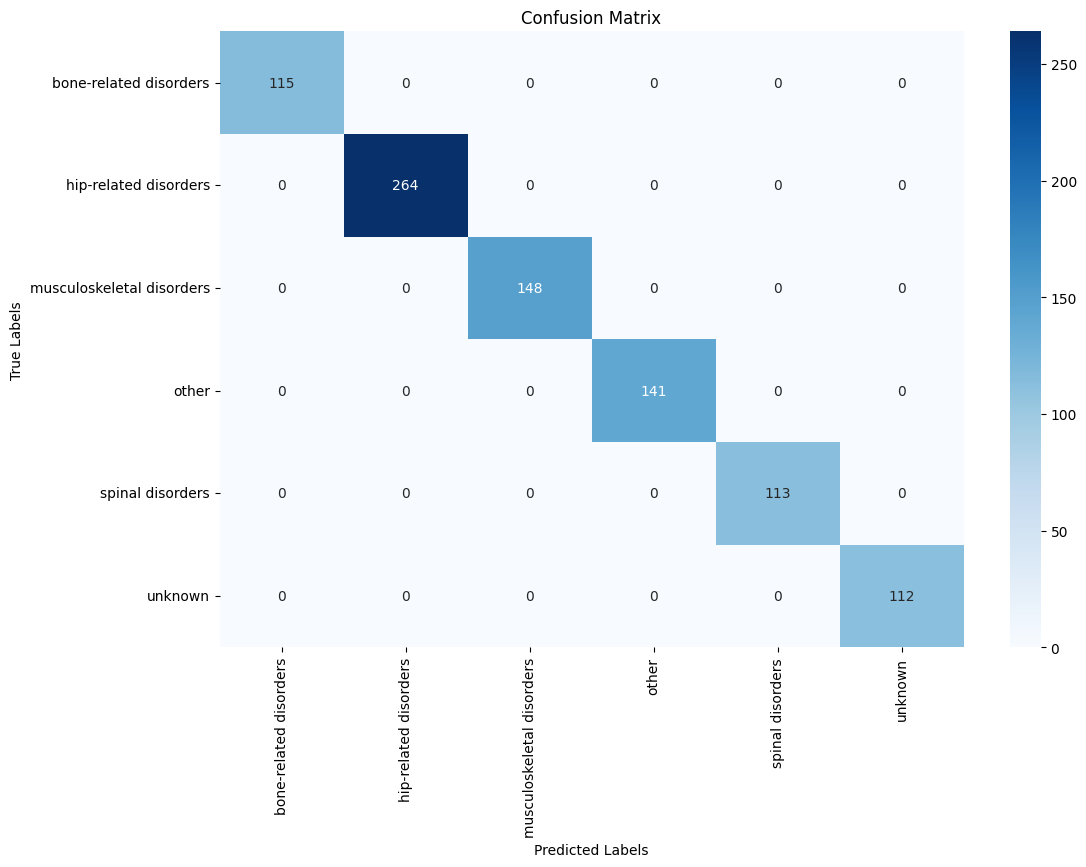

In [9]:
# Create a confusion matrix to analyze misclassifications
conf_matrix = confusion_matrix(val_labels, predicted_labels)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(12, 8))  # Set the figure size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.values(), yticklabels=label_encoder.values())  # Heatmap settings
plt.xlabel("Predicted Labels")  # Label for the x-axis
plt.ylabel("True Labels")  # Label for the y-axis
plt.title("Confusion Matrix")  # Title for the heatmap
plt.show()  # Display the heatmap

**Cross-Validation Setup:**

In [10]:
# **Define a Function to Compute Evaluation Metrics**
# This function computes evaluation metrics such as accuracy based on predictions and true labels.
def compute_metrics(pred):
    # `pred.predictions` contains the model's raw predictions (logits), we take the argmax along axis 1 to get the predicted class index.
    predictions = np.argmax(pred.predictions, axis=1)

    # Compute accuracy by comparing the predicted labels to the true labels (pred.label_ids).
    return {"accuracy": accuracy_score(pred.label_ids, predictions)}  # Return the accuracy score as a dictionary

# **Cross-Validation Setup**
# Initialize KFold cross-validation with 5 splits, shuffle the data, and set the random seed for reproducibility.
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Use 5 splits for cross-validation, shuffle the data, and set the random state to 42 for reproducibility

# **List to Store Results**
# Initialize an empty list to store the results from each fold of the cross-validation.
fold_results = []  # This will hold the results of each fold's evaluation (e.g., accuracy)


**Train and Evaluate Model Per Fold and Confusion Matrix Plot Per Fold And Display Result:**

In [11]:
# **Import Libraries**
# Import necessary modules for data handling, training, evaluation, and visualization.
from torch.utils.data import Subset  # For creating subsets of datasets
from sklearn.utils.class_weight import compute_class_weight  # For computing class weights (balanced weights)
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix  # For evaluation metrics and confusion matrix
import numpy as np  # For numerical operations
import torch  # PyTorch for deep learning
from transformers import (
    DistilBertForSequenceClassification,  # DistilBERT model for sequence classification
    Trainer,  # Trainer class for training and evaluation
    TrainingArguments,  # Training arguments to set up training parameters
)
#import matplotlib.pyplot as plt  # For plotting
#import seaborn as sns  # For creating heatmaps (used for confusion matrix)

# **Loop through KFold splits**
# Loop through each fold in the K-Fold cross-validation.
# `kf.split()` returns train and validation indices for each fold.
pred_history = []
val_history = []

for fold, (train_idx, val_idx) in enumerate(kf.split(full_dataset)):
    print(f"***** Fold {fold + 1} *****")  # Print the current fold number

    # **Subset datasets for training and validation**
    # Subset the dataset into training and validation subsets based on the indices from the KFold split.
    train_dataset = Subset(full_dataset, train_idx)  # Create a training subset for the current fold
    val_dataset = Subset(full_dataset, val_idx)  # Create a validation subset for the current fold

    # **Load the DistilBERT model for sequence classification**
    # Load a pre-trained DistilBERT model from Hugging Face's model hub for classification tasks.
    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',  # Pre-trained model
        num_labels=len(df_balanced['Pseudonymized_Diagnosis Category'].unique())  # Number of unique labels in the target variable
    )

    # **Compute class weights**
    # Compute class weights to account for class imbalance. This helps to avoid the model being biased towards the dominant class.
    class_weights = compute_class_weight(
        'balanced',  # Compute weights based on the imbalance of class frequencies
        classes=np.unique(df_balanced['Pseudonymized_Diagnosis Category']),  # Get the unique categories (labels)
        y=df_balanced['Pseudonymized_Diagnosis Category']  # Target variable
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)  # Convert class weights to tensor and move to the correct device (GPU/CPU)

    # **Define training arguments**
    # Set up various training parameters (learning rate, batch size, epochs, etc.)
    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold + 1}",  # Directory to save results for the current fold
        evaluation_strategy="epoch",  # Evaluate the model at the end of each epoch
        save_strategy="epoch",  # Save model checkpoints at the end of each epoch
        learning_rate=3e-5,  # Set learning rate
        per_device_train_batch_size=16,  # Set batch size for training
        per_device_eval_batch_size=16,  # Set batch size for evaluation
        num_train_epochs=5,  # Number of epochs to train the model
        weight_decay=0.1,  # Weight decay (regularization) to prevent overfitting
        logging_dir=f'./logs_fold_{fold + 1}',  # Directory to save logs for the current fold
        save_total_limit=2,  # Limit the number of saved model checkpoints
        load_best_model_at_end=True,  # Load the best model after training
        metric_for_best_model="accuracy",  # Metric used to select the best model (based on accuracy)
        fp16=True,  # Use 16-bit precision for faster training on supported hardware (e.g., GPUs)
        report_to="none",  # Disable reporting to external services (e.g., TensorBoard, WandB)
    )

    # **Define the Trainer**
    # Create a Trainer object that will handle the training and evaluation process.
    trainer = Trainer(
        model=model,  # The model to be trained
        args=training_args,  # The training arguments
        train_dataset=train_dataset,  # Training dataset for the current fold
        eval_dataset=val_dataset,  # Validation dataset for the current fold
        compute_metrics=compute_metrics,  # Function to compute evaluation metrics (e.g., accuracy)
        tokenizer=tokenizer,  # Tokenizer to preprocess text input
    )

    # **Train the model**
    # Train the model using the Trainer object.
    trainer.train()  # Start the training process

    # **Evaluate the model**
    # After training, evaluate the model's performance on the validation dataset.
    val_results = trainer.evaluate(val_dataset)  # Evaluation results on the validation set
    predictions = trainer.predict(val_dataset)  # Model predictions on the validation set

    # **Get predicted labels as string**
    # Convert numerical predictions into corresponding label strings using the label encoder.
    predicted_labels = [
        label_encoder[label] for label in np.argmax(predictions.predictions, axis=1)
    ]
    pred_history.extend(predicted_labels)

    # **Get true labels as string**
    # Convert true labels from the validation set into corresponding label strings.
    val_labels = [
        label_encoder[int(full_dataset[int(i)]['labels'])] for i in val_idx
    ]
    val_history.extend(val_labels)

    # **Compute evaluation metrics**
    # Calculate accuracy and classification report for the current fold.
    fold_accuracy = accuracy_score(val_labels, predicted_labels)  # Calculate accuracy
    fold_classification_report = classification_report(
        val_labels,  # True labels
        predicted_labels,  # Predicted labels
        target_names=df_balanced['Pseudonymized_Diagnosis Category'].unique()  # List of target class names
    )

    # **Print fold results**
    # Print the accuracy and classification report for the current fold.
    print(f"Fold {fold + 1} Accuracy: {fold_accuracy}")  # Print accuracy
    print(f"Fold {fold + 1} Classification Report:\n{fold_classification_report}")  # Print classification report

    # **Compute confusion matrix**
    # Compute the confusion matrix to show the number of true positive, true negative, false positive, and false negative predictions.
    # cm = confusion_matrix(val_labels, predicted_labels)

    # # **Plot confusion matrix**
    # # Visualize the confusion matrix using a heatmap.
    # plt.figure(figsize=(8, 6))  # Set figure size for the plot
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df_balanced['Diagnosis Category'].unique(),
    #             yticklabels=df_balanced['Diagnosis Category'].unique())  # Create heatmap with annotations
    # plt.title(f'Confusion Matrix - Fold {fold + 1}')  # Title of the confusion matrix plot
    # plt.xlabel('Predicted')  # X-axis label
    # plt.ylabel('Actual')  # Y-axis label
    # plt.show()  # Display the plot

    # **Store fold results**
    # Store the results for the current fold (accuracy and classification report).
    fold_results.append({
        "fold": fold + 1,  # Fold number
        "accuracy": fold_accuracy,  # Accuracy for the fold
        "classification_report": fold_classification_report  # Classification report for the fold
    })

***** Fold 1 *****


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-166991ab3be5>:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.036400,0.994401
2,No log,0.015506,0.994401
3,0.125800,0.007797,0.997760
4,0.125800,0.001406,1.000000
5,0.003600,0.000769,1.000000


Fold 1 Accuracy: 1.0
Fold 1 Classification Report:
                           precision    recall  f1-score   support

    hip-related disorders       1.00      1.00      1.00       115
                  unknown       1.00      1.00      1.00       264
   bone-related disorders       1.00      1.00      1.00       148
musculoskeletal disorders       1.00      1.00      1.00       141
                    other       1.00      1.00      1.00       113
         spinal disorders       1.00      1.00      1.00       112

                 accuracy                           1.00       893
                macro avg       1.00      1.00      1.00       893
             weighted avg       1.00      1.00      1.00       893

***** Fold 2 *****


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-166991ab3be5>:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.022230,0.996641
2,No log,0.005468,0.998880
3,0.123100,0.001213,1.000000
4,0.123100,0.000761,1.000000
5,0.003100,0.000683,1.000000


Fold 2 Accuracy: 1.0
Fold 2 Classification Report:
                           precision    recall  f1-score   support

    hip-related disorders       1.00      1.00      1.00       122
                  unknown       1.00      1.00      1.00       244
   bone-related disorders       1.00      1.00      1.00       155
musculoskeletal disorders       1.00      1.00      1.00       165
                    other       1.00      1.00      1.00       106
         spinal disorders       1.00      1.00      1.00       101

                 accuracy                           1.00       893
                macro avg       1.00      1.00      1.00       893
             weighted avg       1.00      1.00      1.00       893

***** Fold 3 *****


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-166991ab3be5>:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.014176,0.997758
2,No log,0.011646,0.996637
3,0.127000,0.020667,0.995516
4,0.127000,0.003092,0.998879
5,0.003700,0.000788,1.000000


Fold 3 Accuracy: 1.0
Fold 3 Classification Report:
                           precision    recall  f1-score   support

    hip-related disorders       1.00      1.00      1.00       128
                  unknown       1.00      1.00      1.00       250
   bone-related disorders       1.00      1.00      1.00       156
musculoskeletal disorders       1.00      1.00      1.00       148
                    other       1.00      1.00      1.00       101
         spinal disorders       1.00      1.00      1.00       109

                 accuracy                           1.00       892
                macro avg       1.00      1.00      1.00       892
             weighted avg       1.00      1.00      1.00       892

***** Fold 4 *****


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-166991ab3be5>:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.006877,1.000000
2,No log,0.002286,1.000000
3,0.125900,0.001107,1.000000
4,0.125900,0.000833,1.000000
5,0.002500,0.000746,1.000000


Fold 4 Accuracy: 1.0
Fold 4 Classification Report:
                           precision    recall  f1-score   support

    hip-related disorders       1.00      1.00      1.00       125
                  unknown       1.00      1.00      1.00       244
   bone-related disorders       1.00      1.00      1.00       155
musculoskeletal disorders       1.00      1.00      1.00       164
                    other       1.00      1.00      1.00       105
         spinal disorders       1.00      1.00      1.00        99

                 accuracy                           1.00       892
                macro avg       1.00      1.00      1.00       892
             weighted avg       1.00      1.00      1.00       892

***** Fold 5 *****


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-166991ab3be5>:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.008559,0.998879
2,No log,0.012066,0.997758
3,0.128200,0.004699,0.998879
4,0.128200,0.000997,1.000000
5,0.002900,0.000824,1.000000


Fold 5 Accuracy: 1.0
Fold 5 Classification Report:
                           precision    recall  f1-score   support

    hip-related disorders       1.00      1.00      1.00       108
                  unknown       1.00      1.00      1.00       256
   bone-related disorders       1.00      1.00      1.00       180
musculoskeletal disorders       1.00      1.00      1.00       154
                    other       1.00      1.00      1.00       103
         spinal disorders       1.00      1.00      1.00        91

                 accuracy                           1.00       892
                macro avg       1.00      1.00      1.00       892
             weighted avg       1.00      1.00      1.00       892



**Classification Report With Average Accuracy:**

In [12]:
# Optional: Print classification reports
for fold, result in enumerate(fold_results):
    print(f"Classification Report for Fold {fold + 1}")
    print(result["classification_report"])


# Summarize results across all folds
accuracies = [result["accuracy"] for result in fold_results]
print(f"Average Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")


Classification Report for Fold 1
                           precision    recall  f1-score   support

    hip-related disorders       1.00      1.00      1.00       115
                  unknown       1.00      1.00      1.00       264
   bone-related disorders       1.00      1.00      1.00       148
musculoskeletal disorders       1.00      1.00      1.00       141
                    other       1.00      1.00      1.00       113
         spinal disorders       1.00      1.00      1.00       112

                 accuracy                           1.00       893
                macro avg       1.00      1.00      1.00       893
             weighted avg       1.00      1.00      1.00       893

Classification Report for Fold 2
                           precision    recall  f1-score   support

    hip-related disorders       1.00      1.00      1.00       122
                  unknown       1.00      1.00      1.00       244
   bone-related disorders       1.00      1.00      1.00   

**Confusion Matrix Plot:**

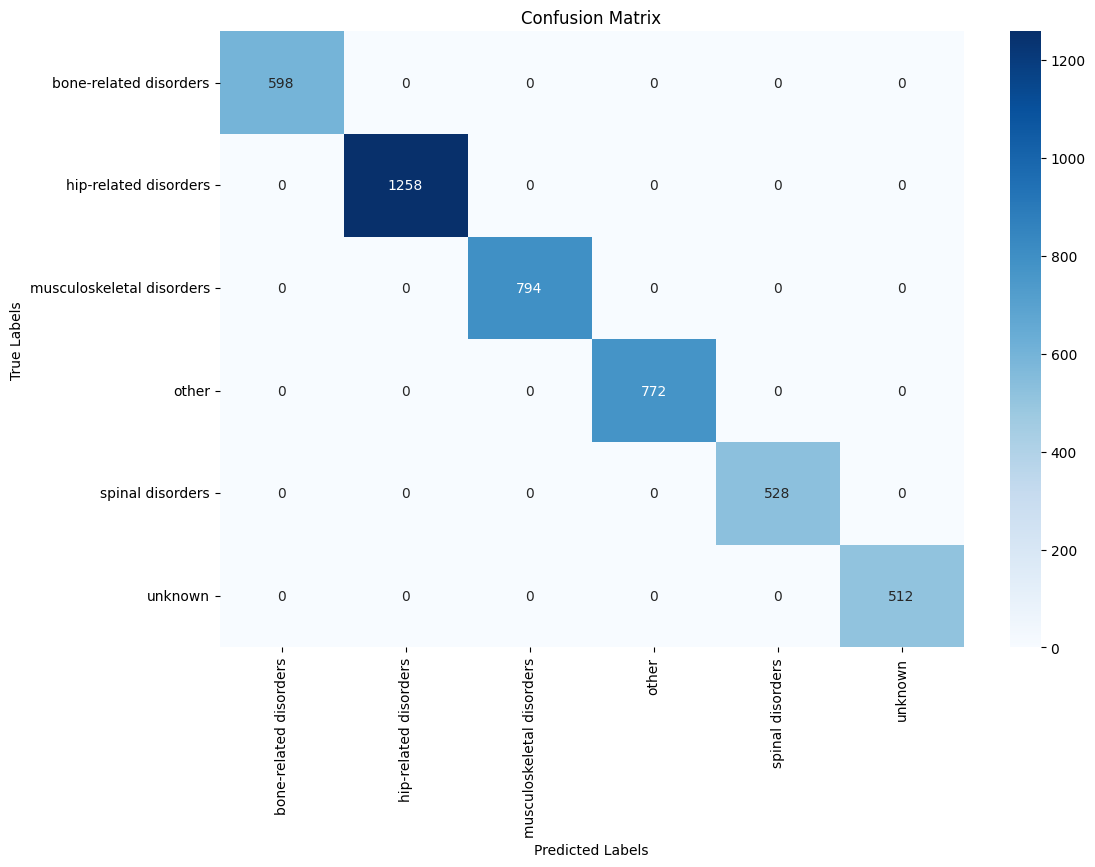

In [13]:
# Create a confusion matrix to analyze misclassifications
conf_matrix = confusion_matrix(val_history, pred_history)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(12, 8))  # Set the figure size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.values(), yticklabels=label_encoder.values())  # Heatmap settings
plt.xlabel("Predicted Labels")  # Label for the x-axis
plt.ylabel("True Labels")  # Label for the y-axis
plt.title("Confusion Matrix")  # Title for the heatmap
plt.show()  # Display the heatmap

**Spelling Correction and Synonym Extraction Functions:**

In [14]:
# Importing necessary libraries for text processing
from nltk.corpus import wordnet  # Used for fetching synonyms from WordNet
from textblob import TextBlob  # Used for spelling correction
import torch  # Used for defining the computation device (CPU or GPU)

# Define device: check if CUDA-enabled GPU is available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define a spelling correction function using TextBlob
# TextBlob provides a simple way to correct spelling errors in text.
def correct_spelling(text):
    return str(TextBlob(text).correct())  # Returns the corrected text as a string

# Function to get synonyms for a list of keywords using WordNet
# This function searches for synonyms of each word in the provided list using WordNet.
def get_synonyms(keywords):
    synonyms = set(keywords)  # Initialize a set with the original keywords to avoid duplicates
    for keyword in keywords:  # Iterate through each keyword in the list
        for syn in wordnet.synsets(keyword):  # Fetch all synsets (group of synonyms) for the keyword
            for lemma in syn.lemmas():  # For each synonym (lemma) in the synset
                synonyms.add(lemma.name().lower())  # Add the lemma name to the set (converted to lowercase)
    return list(synonyms)  # Convert the set of synonyms to a list and return it

# Define keywords for different medical categories and extract their synonyms
# These lists contain keywords related to different body parts or medical conditions.

spinal_keywords = get_synonyms(["spine", "spinal", "vertebrae", "backbone", "disk", "sciatica"])
# Get synonyms for keywords related to spinal issues, such as "spine", "vertebrae", etc.

non_spinal_keywords = get_synonyms(["wrist", "knee", "ankle","elbow", "shoulder","muscles"])
# Get synonyms for keywords related to non-spinal body parts like "wrist", "knee", etc.

hip_keywords = get_synonyms(["hip", "groin", "thigh", "pelvis", "squat"])
# Get synonyms for keywords related to the hip region and associated terms like "groin", "thigh", etc.

bone_keywords = get_synonyms(["bone", "fracture", "osteoporosis", "rib", "shin"])
# Get synonyms for keywords related to bones and fractures, such as "bone", "fracture", etc.

other_keywords = get_synonyms(["Fever","Fatigue with low energy", "Loss of appetite", "Occasional dizziness", "Dry cough","Sneezing", "cough", "sore throat", "diarrhea", "abdominal pain", "headache", "fatigue","Loose motion", "nausea", "vomiting", "shortness of breath", "chest pain", "dizziness", "numbness", "rashes", "swelling", "frequent urination", "painful urination", "anxiety", "depression", "rhinorrhea", "cephalgia", "sneezing","Sneezing with watery eyes", "stuffy nose", "loss of appetite", "low energy","headache", "high temperature", "chills", "malaise", "dry cough", "productive cough", "congestion", "stomachache", "migraine", "light-headedness", "exhaustion", "weakness", "vomiting sensation", "bloating", "breathing difficulty", "chest tightness", "fainting", "tingling", "redness", "irritation", "inflammation", "bloating", "frequent trips to the bathroom", "panic", "stress", "runny nose", "sinus blockage", "lethargy"])

**Advanced Prediction Function with Hierarchical Logic:**




In [15]:
# Define the function to make predictions using dynamic batch processing and advanced keyword-based classification
def predict_dynamic_batch_with_advanced_keywords(texts):
    # Correct spelling of input texts using the previously defined function
    corrected_texts = [correct_spelling(text) for text in texts]  # Apply spelling correction to each text in the input list

    # Tokenize the corrected texts using the tokenizer, returning PyTorch tensors
    inputs = tokenizer(corrected_texts, return_tensors="pt", truncation=True, max_length=256, padding=True).to(device)
    # Tokenizer converts the text to token IDs, truncating texts longer than 256 tokens, padding shorter ones

    with torch.no_grad():  # Disable gradient calculation for inference (saves memory)
        outputs = model(**inputs)  # Pass the tokenized inputs through the model
        logits = outputs.logits  # Extract the logits (raw model predictions) from the output
        predicted_classes = torch.argmax(logits, dim=-1).cpu().numpy()  # Get the predicted classes by selecting the max logit

    # Convert the predicted classes into human-readable labels
    predictions = [list(label_encoder.values())[cls] for cls in predicted_classes]  # Map predicted class indices to labels

    # Loop through each corrected text and check for specific keywords related to disorders
    for i, text in enumerate(corrected_texts):
        text_lower = text.lower()  # Convert text to lowercase for case-insensitive keyword matching

        # Check if any hip-related keyword is present in the text
        if any(keyword in text_lower for keyword in hip_keywords):
            predictions[i] = "hip-related disorders"  # Set prediction to 'hip-related disorders' if match is found

        # Check if any spinal-related keyword is present, and ensure no non-spinal keyword is present
        elif any(keyword in text_lower for keyword in spinal_keywords) and not any(
            keyword in text_lower for keyword in non_spinal_keywords
        ):
            predictions[i] = "spinal disorders"  # Set prediction to 'spinal disorders' if match is found

        # Check if any bone-related keyword is present in the text
        elif any(keyword in text_lower for keyword in bone_keywords):
            predictions[i] = "bone-related disorders"  # Set prediction to 'bone-related disorders' if match is found

        # Check if any musculoskeletal keyword is present in the text (excluding spinal keywords)
        elif any(keyword in text_lower for keyword in non_spinal_keywords):
            predictions[i] = "musculoskeletal disorders"  # Set prediction to 'musculoskeletal disorders' if match is found

        # Default to the model's prediction if no relevant keywords are found
        else:
            predictions[i] = "others"  # Default category if no specific keywords are matched

    return predictions  # Return the final list of predictions based on the logic and model output

**Test Samples and Prediction Generation with Advanced Logic:**

In [16]:
# Define a list of orthopedic sample texts for classification
orthopedic_samples = [
    "Sharp pain in the lower back, spreading to the right leg, worsens while standing for long durations.",
    "Swelling and tenderness in the left ankle after playing basketball, difficulty bearing weight.",
    "Persistent pain in the upper back, worsens when lifting heavy objects or twisting.",
    "Pain and stiffness in the neck, accompanied by a headache after prolonged computer use.",
    "Difficulty gripping objects due to sharp pain in the thumb and wrist area.",
    "Pain in the hips while sitting cross-legged, with occasional stiffness in the groin.",
    "Burning sensation and numbness in the toes after long-distance walking.",
    "Pain in the elbow after repetitive movements like throwing or lifting, difficulty extending the arm.",
    "Throbbing pain in the heel after running, especially noticeable first thing in the morning.",
    "Stiffness and pain in the shoulders after sleeping on one side, reduced arm mobility.",
    "weaknesss in body,felling restless,not able to sleep properly,anxiety.",
    "stiffness in boduy in winters.",
    "Pain in hip area, Restricted movement, Difficulty walkin.",
    "Improvement in limb strength, reduced numbness, enhanced coordination, and decreased pain.",
    "bone fractured in an accident.",
    "Bone soreness, Signs of fractures, Limited joint mobility, Bone thinning.",
    "Bone soreness, Osteoporosis symptoms, Restricted movement, Bone thinning.",
    "Ache in bones, Weak bones, Limited joint mobility, Decreased bone density.",
    "Chronic bone pain, Weakness in bones, Difficulty walking, Reduced bone strength.",
    "Frequent bone fractures, Decreased bone density, Pain in limbs, Limited mobility.",
    "Sharp pain in bones, Bone swelling, Difficulty bearing weight, Decreased bone flexibility.",
    "Swelling in joints, Limited bone strength, Stiffness in joints, Bone pain after injury.",
    "Bone aches, Reduced range of motion, Muscle stiffness, Reduced bone mass.",
    "Fractured bone, Pain at fracture site, Bruising, Swelling, Limited joint motion.",
    "Persistent bone pain, Difficulty walking, Bone weakness, Joint stiffness.",
    "Bone fracture in a fall, Limited mobility in affected limb, Bruising around bone.",
    "Generalized bone soreness, Bone fragility, Decreased movement, Joint discomfort.",
    "Constant aching in bones, Limited movement, Increased pain with physical activity, Decreased bone strength.",
    "Pain in joints, Swelling around joints, Stiffness, Difficulty in mobility.",
    "Chronic lower back pain, Reduced flexibility, Spinal stiffness, Muscle spasms.",
    "Frequent fractures, Bone tenderness, Decreased bone density, Bone deformities.",
    "Pain in knees, Limited movement, Swelling in joints, Bone tenderness.",
    "Pain in hips, Reduced joint mobility, Decreased range of motion, Bone stiffness.",
    "Bone pain, Difficulty walking, Swelling and tenderness in bones, Limited movement.",
    "Weak bones, Brittle bones, Difficulty standing for long periods, Muscle weakness.",
    "Pain in wrists, Limited range of motion, Bone deformities, Difficulty gripping objects.",
    "Joint pain, Decreased bone mass, Weakness in limbs, Bone thinning.",
    "Severe pain in bones, Increased fractures with minor injury, Reduced bone strength, Difficulty climbing stairs.",
    "Bone bruising, Pain after injury, Decreased mobility in injured area, Difficulty bearing weight.",
    "Stiffness in bones, Limited bone growth, Pain during physical activity, Reduced muscle strength.",
    "Decreased bone density, Bone aches, Loss of height, Difficulty standing upright.",
    "Severe pain in legs, Bone fractures, Swelling in joints, Difficulty walking or running.",
    "Chronic pain in shoulders, Bone tenderness, Decreased shoulder movement, Weakness in upper limbs.",
    "Chronic lower back pain, Limited flexibility, Spinal stiffness, Muscle spasms.",
    "Persistent pain in the spine, Difficulty in maintaining posture, Numbness in legs, Limited movement.",
    "Sharp pain in the back, Reduced range of motion, Stiffness in the neck, Pain radiating to shoulders.",
    "Lower back stiffness, Pain after sitting for long periods, Muscle weakness, Difficulty standing upright.",
    "Numbness in back, Loss of flexibility in spine, Spinal compression, Shooting pain down the legs.",
    "Spinal misalignment, Severe pain when bending, Limited neck movement, Headaches.",
    "Pain and tightness in the back, Difficulty walking long distances, Limited spinal mobility.",
    "Shooting pain in lower back, Difficulty lifting heavy objects, Weakness in legs, Numbness.",
    "Pain when sitting, Herniated disc symptoms, Radiating pain down legs, Reduced spinal flexibility.",
    "Chronic neck pain, Stiffness in upper spine, Radiating pain into arms, Limited range of motion.",
    "Spinal curvature, Pain when twisting torso, Numbness in lower back, Tightness in spine muscles.",
    "Shooting pain from lower back to legs, Numbness, Limited spinal movement, Muscle spasms.",
    "Headache"
]

# Generate predictions using the previously defined function with advanced keyword-based logic
predicted_categories = predict_dynamic_batch_with_advanced_keywords(orthopedic_samples)

# Output the refined predictions for each sample
for text, category in zip(orthopedic_samples, predicted_categories):
    # Print the original text and the predicted category for each sample
    print(f"Input: {text}\nPredicted Category: {category}\n")

Input: Sharp pain in the lower back, spreading to the right leg, worsens while standing for long durations.
Predicted Category: spinal disorders

Input: Swelling and tenderness in the left ankle after playing basketball, difficulty bearing weight.
Predicted Category: musculoskeletal disorders

Input: Persistent pain in the upper back, worsens when lifting heavy objects or twisting.
Predicted Category: spinal disorders

Input: Pain and stiffness in the neck, accompanied by a headache after prolonged computer use.
Predicted Category: others

Input: Difficulty gripping objects due to sharp pain in the thumb and wrist area.
Predicted Category: musculoskeletal disorders

Input: Pain in the hips while sitting cross-legged, with occasional stiffness in the groin.
Predicted Category: hip-related disorders

Input: Burning sensation and numbness in the toes after long-distance walking.
Predicted Category: others

Input: Pain in the elbow after repetitive movements like throwing or lifting, diffi

In [17]:
additional_samples = [
    "Sharp pain in the lower back with occasional tingling sensations down the left leg.",
    "Swollen knee joint with restricted range of motion and pain during movement.",
    "A dull ache in the shoulder that becomes severe after overhead lifting.",
    "Stiff neck with pain radiating to the upper back after sleeping in an awkward position.",
    "Burning pain in the feet after standing for long periods at work.",
    "Shooting pain in the lower back with muscle spasms, worsens when bending forward.",
    "Tingling and numbness in the hand, especially after holding heavy objects.",
    "Painful swelling and bruising on the wrist after a fall while jogging.",
    "Dull pain and discomfort in the thighs after sitting for prolonged hours.",
    "Tightness in the lower back with reduced flexibility during physical activities.",
    "Sharp pain in the Achilles tendon, aggravated by running or jumping.",
    "Tiredness and fatigue in the legs after a long day of walking or standing.",
    "Stiffness and aching in the back of the knee after long car rides.",
    "Pain and swelling in the elbow joint after repetitive sports activities.",
    "Persistent pain in the ankle after twisting it while walking on uneven ground.",
    "bone fractured in an accident"
]
# Generate predictions with the advanced logic
predicted_categories = predict_dynamic_batch_with_advanced_keywords(additional_samples)

# Output the refined predictions
for text, category in zip(additional_samples, predicted_categories):
    print(f"Input: {text}\nPredicted Category: {category}\n")

Input: Sharp pain in the lower back with occasional tingling sensations down the left leg.
Predicted Category: spinal disorders

Input: Swollen knee joint with restricted range of motion and pain during movement.
Predicted Category: musculoskeletal disorders

Input: A dull ache in the shoulder that becomes severe after overhead lifting.
Predicted Category: musculoskeletal disorders

Input: Stiff neck with pain radiating to the upper back after sleeping in an awkward position.
Predicted Category: spinal disorders

Input: Burning pain in the feet after standing for long periods at work.
Predicted Category: others

Input: Shooting pain in the lower back with muscle spasms, worsens when bending forward.
Predicted Category: musculoskeletal disorders

Input: Tingling and numbness in the hand, especially after holding heavy objects.
Predicted Category: others

Input: Painful swelling and bruising on the wrist after a fall while jogging.
Predicted Category: musculoskeletal disorders

Input: Du

In [19]:
new_samples = [
     "Sharp pain radiating from the lower back to the thighs, worsens with prolonged sitting.",
     "Swelling and sharp pain in the wrist after lifting heavy boxes, limited mobility.",
     "Dull ache in the lower back with a feeling of stiffness after standing for extended periods.",
     "Throbbing pain in the knee joint with difficulty bending and extending the leg.",
     "Tightness in the hamstrings after running long distances, with mild swelling.",
     "Sudden, severe pain in the hip joint when walking or climbing stairs.",
     "Aching and burning sensation in the feet, especially after wearing tight shoes.",
     "Pain and weakness in the shoulder after performing overhead activities.",
     "Stiff neck and sharp pain after a minor car accident, with reduced head movement.",
     "Numbness and tingling sensation in the fingers after typing for several hours.",
     "Pain in the elbow that worsens with repetitive bending and straightening of the arm.",
     "Sharp pain in the lower back while lifting heavy objects, with a tingling sensation down the leg.",
     "Feeling of tightness and discomfort in the thigh area after long flights.",
     "Persistent dull pain in the hips with stiffness, especially in the mornings.",
     "Burning and stabbing pain in the toes, especially after walking long distances.",
     "Pain in the lower back with muscle spasms that occur while bending forward.",
     "Swollen and painful heel after running on hard surfaces, especially noticeable in the morning.",
     "Limited movement and pain in the shoulder joint after an overhead injury.",
     "Sudden sharp pain in the back when twisting while lifting an object.",
     "Constant ache in the knees with swelling after squatting for long periods.",
     "Sharp pain in the hip after falling, with difficulty rotating the leg.",
     "Stiffness and sharp pain in the lower back after sitting at a desk for hours.",
     "Slight pain in the wrist when using a computer mouse for long periods.",
     "Tenderness and pain in the knee after a fall during sports, swelling visible.",
     "Aching pain in the back of the thighs after jogging, worsens at night.",
    "Painful pressure in the lower back with radiating discomfort to the hips.",
    "Bone fractured in an accident."
]
# Generate predictions with the advanced logic
predicted_categories = predict_dynamic_batch_with_advanced_keywords(new_samples)

# Generate predictions with the advanced logic
predicted_categories = predict_dynamic_batch_with_advanced_keywords(additional_samples)

# Output the refined predictions
for text, category in zip(new_samples, predicted_categories):
    print(f"Input: {text}\nPredicted Category: {category}\n")

Input: Sharp pain radiating from the lower back to the thighs, worsens with prolonged sitting.
Predicted Category: spinal disorders

Input: Swelling and sharp pain in the wrist after lifting heavy boxes, limited mobility.
Predicted Category: musculoskeletal disorders

Input: Dull ache in the lower back with a feeling of stiffness after standing for extended periods.
Predicted Category: musculoskeletal disorders

Input: Throbbing pain in the knee joint with difficulty bending and extending the leg.
Predicted Category: spinal disorders

Input: Tightness in the hamstrings after running long distances, with mild swelling.
Predicted Category: others

Input: Sudden, severe pain in the hip joint when walking or climbing stairs.
Predicted Category: musculoskeletal disorders

Input: Aching and burning sensation in the feet, especially after wearing tight shoes.
Predicted Category: others

Input: Pain and weakness in the shoulder after performing overhead activities.
Predicted Category: musculos

In [20]:
more_samples = [
    "Fractured bone in a minor accident, Persistent swelling, Pain while moving, Limited joint mobility.",
    "Bone soreness after injury, Signs of fractures, Difficulty bearing weight, Swelling in affected area.",
    "Sharp pain in bones, Bone fragility, Reduced strength in limbs, Stiffness in joints.",
    "Chronic bone pain, Weakness in bones, Swelling in joints, Decreased bone density.",
    "Frequent fractures, Decreased bone density, Limited movement, Bruising around bones.",


]

# Generate predictions with the advanced logic
predicted_categories = predict_dynamic_batch_with_advanced_keywords(more_samples)

# Output the refined predictions
for text, category in zip(more_samples, predicted_categories):
    print(f"Input: {text}\nPredicted Category: {category}\n")

Input: Fractured bone in a minor accident, Persistent swelling, Pain while moving, Limited joint mobility.
Predicted Category: bone-related disorders

Input: Bone soreness after injury, Signs of fractures, Difficulty bearing weight, Swelling in affected area.
Predicted Category: bone-related disorders

Input: Sharp pain in bones, Bone fragility, Reduced strength in limbs, Stiffness in joints.
Predicted Category: bone-related disorders

Input: Chronic bone pain, Weakness in bones, Swelling in joints, Decreased bone density.
Predicted Category: bone-related disorders

Input: Frequent fractures, Decreased bone density, Limited movement, Bruising around bones.
Predicted Category: bone-related disorders



In [21]:
more_samples1 = [
    "Fever with chills, Sore throat, Nasal congestion, General tiredness",
    "Productive or non-productive cough accompanied by thoracic pain.",
    "Cough with chest pain: Productive or non-productive cough accompanied by thoracic pain.",
    "Rhinorrhea, Cephalgia of mild intensity.",
    "Feverish feeling, Mild nausea, Reduced physical strength.",
    "Feeling cold, cough and higmh fever.",
    "Stomachache and diarrhea.",
    "Fever and cough, pain during urine passage.",
    "Fracture and pain in bone .",
    "I am having Fever.",
    "I am having neck and severe back pain.",
    "I am having muscle ache."


]

# Generate predictions with the advanced logic
predicted_categories = predict_dynamic_batch_with_advanced_keywords(more_samples1)

# Output the refined predictions
for text, category in zip(more_samples1, predicted_categories):
    print(f"Input: {text}\nPredicted Category: {category}\n")

Input: Fever with chills, Sore throat, Nasal congestion, General tiredness
Predicted Category: others

Input: Productive or non-productive cough accompanied by thoracic pain.
Predicted Category: others

Input: Cough with chest pain: Productive or non-productive cough accompanied by thoracic pain.
Predicted Category: others

Input: Rhinorrhea, Cephalgia of mild intensity.
Predicted Category: others

Input: Feverish feeling, Mild nausea, Reduced physical strength.
Predicted Category: others

Input: Feeling cold, cough and higmh fever.
Predicted Category: others

Input: Stomachache and diarrhea.
Predicted Category: others

Input: Fever and cough, pain during urine passage.
Predicted Category: others

Input: Fracture and pain in bone .
Predicted Category: bone-related disorders

Input: I am having Fever.
Predicted Category: others

Input: I am having neck and severe back pain.
Predicted Category: spinal disorders

Input: I am having muscle ache.
Predicted Category: musculoskeletal disorder

In [22]:
more_samples2 = [
     "cold and cough.",
     "wrist pain.",
     "Pain in both the hips,and walking problem.",
     "I am having sever neck pain and back pain.",


]

# Generate predictions with the advanced logic
predicted_categories = predict_dynamic_batch_with_advanced_keywords(more_samples2)

# Output the refined predictions
for text, category in zip(more_samples2, predicted_categories):
    print(f"Input: {text}\nPredicted Category: {category}\n")

Input: cold and cough.
Predicted Category: others

Input: wrist pain.
Predicted Category: musculoskeletal disorders

Input: Pain in both the hips,and walking problem.
Predicted Category: hip-related disorders

Input: I am having sever neck pain and back pain.
Predicted Category: spinal disorders

